In [1]:
%matplotlib inline

import matplotlib.pyplot as plt # traçage de graphiques
import numpy as np # traitement des arrays numériques
import pandas as pd

from sklearn import datasets # datasets classiques
from sklearn import preprocessing # normalisation les données
from sklearn import decomposition # PCA et NMF
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

np.random.seed = 2017 # pour des résultats reproductibles

# 0. Motivations
On peut souhaiter réduire de nombre de dimensions d'un jeu de données :
- pour le compresser : diminution le volume d'informations utiles à stocker et par la même occasion la durée d'exécution d'un algorithme d'apprentisssage (car l'espace à explorer est plus petit)
- pour n'en conserver que les caractéristiques (features) discriminantes et éviter ainsi le surapprentissage (apprentissage du bruit dans les données)

# 1. PCA - L'analyse en composante principale

## 1.1 Algorithme
**L'analyse en composante principale pour des données numériques en n dimensions est un algorithme non supervisé d'identification des dimensions de variance décroissante et de changement de base pour ne conserver que les k dimensions de plus grande variance.**

Il consiste à :

0. *Optionnel : Normaliser les données (important si les données n'ont par exemple pas été mesurées aux mêmes échelles)*
0. Construire la matrice de covariance entre les variables :
$\Sigma = \frac{1}{n-1}\sum_{i=1}^{n}{((X - \bar{x})'(X - \bar{x}))}$
0. Trouver les valeurs propres $\lambda_i$ et vecteurs propres $v_i$ :
$\Sigma v_i = \lambda_iv_i$, ces vecteurs propres forment un repère orthogonal de l'espace des données (en tant que vecteurs propres d'une matrice symmétrique qu'on supposera de rang n)
0. Classer les valeurs propres (et les vecteurs associés) de façon décroissante : $\{\lambda_{(n)}, \lambda_{(n-1)}...\lambda_{(1)} \}$ où $\lambda_{(i)}$ est la i-ème variance dans l'ordre croissant
0. Ne conserver que les k  ($k \leqslant n$)  premiers vecteurs : $\{v_{(n)}, v_{(n-1)}...v_{(n-k+1)} \}$
0. Construire la matrice de projection dans l'espace de ces vecteurs (changement de base si n=k)
0. Projeter les données initiales dans cet espace de dimension k
![Illustration PCA](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f5/GaussianScatterPCA.svg/220px-GaussianScatterPCA.svg.png)

Tout cela peut bien sur être implémenté from scratch avec Numpy mais nous utiliserons ici scikit-learn pour raccourcir l'implémentation et nous concentrer sur la visualisation des résultats.
Cf. https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales et http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

## 1.2 Implémentation avec scikit-learn
### 1.2.1 Données
Nous partirons classiquement du dataset Iris (classification de 3 fleurs sur la base de certaines de leurs mesures) :

In [2]:
iris = datasets.load_iris()
X_iris = iris.data
y_iris = iris.target

Dimensions de l'espace de départ : 4
Représentation des données dans ces dimensions :


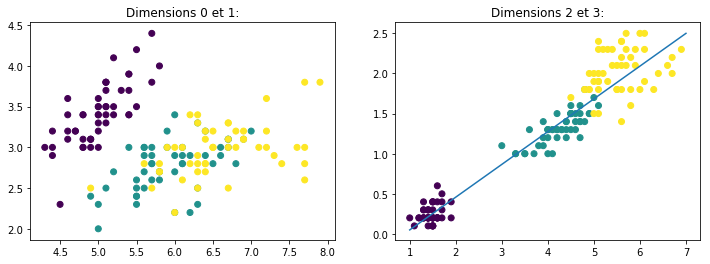

In [3]:
print("Dimensions de l'espace de départ : {}".format(X_iris.shape[1]))
print("Représentation des données dans ces dimensions :")

plt.figure(figsize=(12,4))
plt.subplot(1, 2, 1)
plt.title("Dimensions 0 et 1:")
plt.scatter(X_iris[:, 0], X_iris[:, 1], c=y_iris)
plt.subplot(1, 2, 2)
plt.title("Dimensions 2 et 3:")
plt.scatter(X_iris[:, 2], X_iris[:, 3], c=y_iris)
plt.plot([1,7],[0.05,2.5])
plt.show()

### 1.2.2 Premier exemple de PCA
Graphiquement, on peut se dire que les 2 dernières dimensions sont très corrélées et donc redondantes. Dans un strict but de classification, on pourrait d'ailleurs presque se contenter de la dimension indiquée par la ligne bleue pour correctement discriminer les 3 types de fleurs (*nous verrons par la suite qu'il s'agit d'un cas particulier non généralisable*).

Effectuons une PCA avec scikit-learn avec un changemment de base conservant les 4 dimensions pour illustrer leurs différences :

In [4]:
# Gardons toutes les composantes pour le moment
# Nous pourrons toujours en retirer ensuite puisqu'elles seront triées par significativité
pca = decomposition.PCA(n_components=4)

X_iris_PCA = pca.fit(X_iris).transform(X_iris) 

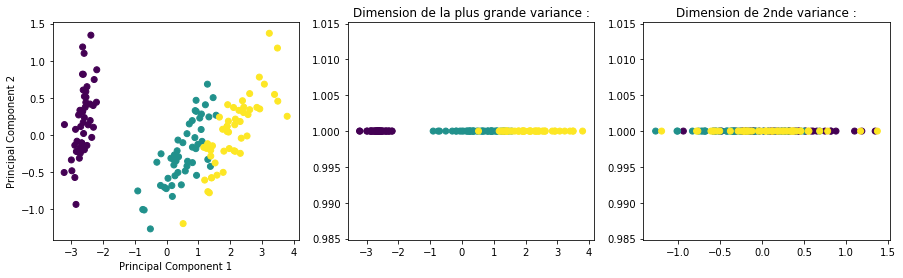

In [5]:
def graph_acp2(X_PC2, y):
    plt.figure(figsize=(15,4))
    plt.subplot(1, 3, 1)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.scatter(X_PC2[:, 0], X_PC2[:, 1], c=y)
    plt.subplot(1, 3, 2)
    plt.title("Dimension de la plus grande variance :")
    plt.scatter(X_PC2[:, 0], np.ones(X_PC2.shape[0]), c=y)
    plt.subplot(1, 3, 3)
    plt.title("Dimension de 2nde variance :")
    plt.scatter(X_PC2[:, 1], np.ones(X_PC2.shape[0]), c=y)
    plt.show()

graph_acp2(X_iris_PCA, y_iris)

## 1.3 Quelques réserves
Comme évoqué dans la présentation, il est à noter qu'il s'agit d'un **algorithme non supervisé**, qui ne tient donc pas compte des étiquettes des données.
Dans le cas ci-dessus, nous avons eu la chance que les données soient linéairement séparables sur la dimension de plus grande variance. Dans le cas contraire, l'ACP aurait pu ne pas nous aider et nous aurions même pu perdre les dimensions selon lesquelles discriminer les données correctement.

A noter également que dans le cas de données de variance assez homogène selon toutes les dimensions, une ACP ne nous apporte rien.

**L'ACP peut donc être inutile voire contreproductive dans un objectif de classification.**

Ci-après 2 contre-exemples :

### 1.3.1 ACP et discrimination selon dimension de moindre variance

In [6]:
X11 = np.random.rand(30)*10
X21 = X11 + 1
X12 = np.random.rand(20)*10
X22 = X12 + 2
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(30), np.ones(20)))
X = preprocessing.scale(X, with_mean=True, with_std=True)

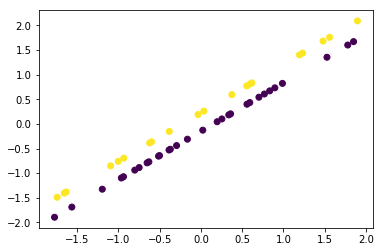

In [7]:
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

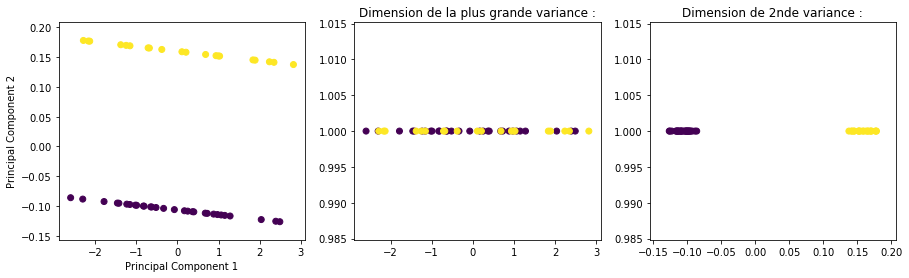

In [8]:
pca = decomposition.PCA(n_components=2)
X_PC2 = pca.fit(X).transform(X)
graph_acp2(X_PC2, y)

Ici une ACP ne retenant que la dimension de plus grande variance nous aurait donc fait perdre toute possibilité de discrimination.

### 1.3.2 ACP sur des données de variance homogène

In [9]:
X11 = np.random.normal(0, 10, 500)
X21 = abs(np.random.normal(0, 10, 500))
X12 = np.random.normal(0, 10, 500)
X22 = -abs(np.random.normal(0, 10, 500))
X = np.array([np.concatenate((X11,X12)),
              np.concatenate((X21,X22))]).T
y = np.concatenate((np.zeros(500), np.ones(500)))
y = y.astype(int)

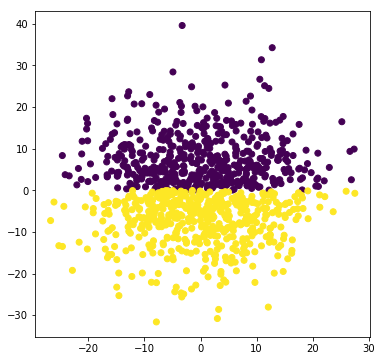

In [10]:
plt.figure(figsize=(6,6))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [11]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_PC2 = pca.transform(X)

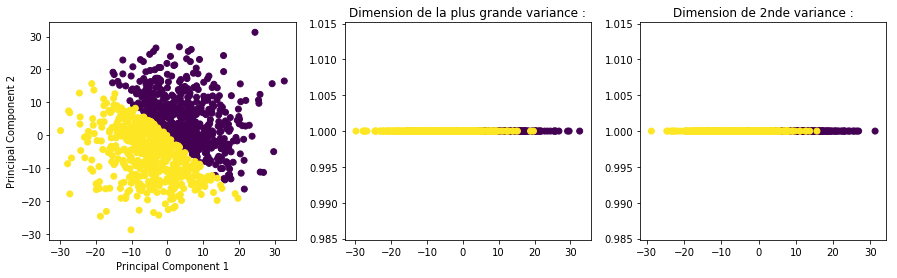

In [12]:
graph_acp2(X_PC2, y)    

Ici une ACP est inutile car la variance des données est homogène selon les dimensions initiales (cf. orientation diagonale entre les 2 classes).

# 2. Autres méthodes
D'autres méthodes, que nous détaillerons moins pour le moment, peuvent être plus pertinentes que l'ACP dans certains contextes :

## 2.1 L'[analyse discriminante linéaire ou quadratique](http://scikit-learn.org/stable/modules/lda_qda.html) (LDA/QDA)
Maximise la variance inter-classes par rapport à celle intra classe : plus adaptée que l'ACP dans un objectif de classification.

Rappel des composantes identifiées par le PCA :


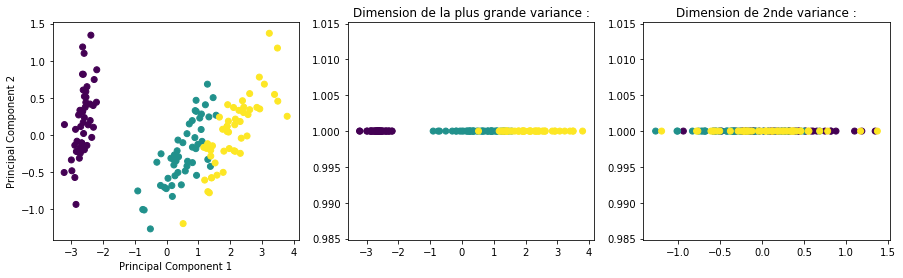

Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :


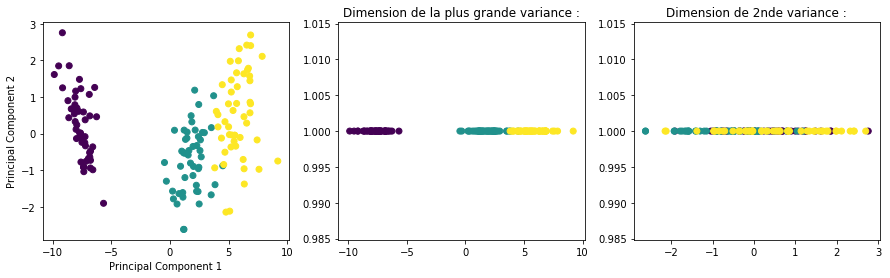

In [13]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_iris_LDA = lda.fit(X_iris, y_iris).transform(X_iris)

print("Rappel des composantes identifiées par le PCA :")
graph_acp2(X_iris_PCA, y_iris) 
print("Composantes identifiées par le LDA (on remarque une meilleure séparation des classes sur la 1ère composante) :")
graph_acp2(X_iris_LDA, y_iris) 

# 2.1La [factorisation de matrices](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)
On approche une matrice M\*N, de grande taille souvent creuse et positive (e.g. les évaluations de touts les clients sur tous les produits dans un site marchand), par un produit d'une matrice M\*K (e.g. le profils de tous les clients) avec une matrice K\*N (e.g. les évaluations moyennes pour ces profils) avec (M\*K + K\*N) << M\*N

A titre d'exemple construisons une matrice de notations de films par des utilisateurs que nous allons tâcher de factoriser en une matrice de profils (les goûts de chaque utilisateurs) et une autre de catégories de films (les profils auxquels ses films sont susceptibles de plaire).

In [14]:
df = pd.DataFrame.from_dict({'loves everything': [9,9,9,9,9,9,0],
                             'loves guns':       [1,2,1,8,9,8,9],
                             'testosterone guy': [0,0,1,9,9,9,7],
                             'girly girl':       [9,0,8,1,0,0,7],
                             'romance addict':   [9,8,0,0,0,1,0],
                             'macho man':        [0,1,0,8,7,9,8],
                             'loves flowers':    [7,8,0,0,0,0,8],
                             'easily pleased':   [0,8,8,0,7,9,7],
                             'chuck norris fan': [0,2,0,9,0,9,8],
                             'mylittleponey98':  [7,0,7,0,1,0,8],
                             'all movies rock':  [7,8,0,0,7,8,7],
                             'more guns please': [0,2,0,9,8,0,7],
                             'yeah guns!':       [1,0,3,0,9,9,0]},
                           ).transpose()
df.index.name = "Users"
df.columns = ['Charming prince', 'First date', 'Lovely love', 'Guns are cool', 'Ultra badass 4', 'My fist in your face', 'Guns & roses']
df.columns.name = "Movies"
df

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
Users,,,,,,,
all movies rock,7,8,0,0,7,8,7
chuck norris fan,0,2,0,9,0,9,8
easily pleased,0,8,8,0,7,9,7
girly girl,9,0,8,1,0,0,7
loves everything,9,9,9,9,9,9,0
loves flowers,7,8,0,0,0,0,8
loves guns,1,2,1,8,9,8,9
macho man,0,1,0,8,7,9,8
more guns please,0,2,0,9,8,0,7


In [15]:
nmf = decomposition.NMF(n_components=2,
                        random_state=1,
                        alpha=.1,
                        l1_ratio=.5).fit(df)

In [16]:
profiles = pd.DataFrame(nmf.transform(df),
                        index=df.index,
                        columns=['action lover', 'romcom lover'])
profiles

,action lover,romcom lover
Users,,
all movies rock,1.364464,1.788403
chuck norris fan,1.945916,0.072006
easily pleased,1.649300,1.397724
girly girl,0.031053,2.159935
loves everything,1.847780,2.263489
loves flowers,0.092489,2.079689
loves guns,2.542310,0.229329
macho man,2.436259,0.000000
more guns please,1.755344,0.047097


In [17]:
profiles = profiles > 1
profiles

,action lover,romcom lover
Users,,
all movies rock,True,True
chuck norris fan,True,False
easily pleased,True,True
girly girl,False,True
loves everything,True,True
loves flowers,False,True
loves guns,True,False
macho man,True,False
more guns please,True,False


In [18]:
movie_cat = pd.DataFrame(nmf.components_,
                         columns=df.columns,
                         index=['action lover', 'romcom lover'])
movie_cat = movie_cat > 1

In [19]:
movie_cat

Movies,Charming prince,First date,Lovely love,Guns are cool,Ultra badass 4,My fist in your face,Guns & roses
action lover,False,False,False,True,True,True,True
romcom lover,True,True,True,False,False,False,True


Nous avons donc bien obtenu une matrice de profils et une autre de catégories de films dont la multiplication nous donnera approximativement les goûts des utilisateurs pour chaque film, y compris ceux qu'ils n'ont pas vus ou évalués.